In [23]:
import sys
print(sys.version)
print(sys.platform)

3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
win32


In [24]:
import sys, sklearn, numpy, joblib, imblearn

print("Python:", sys.version)
print("scikit-learn:", sklearn.__version__)
print("numpy:", numpy.__version__)
print("joblib:", joblib.__version__)
print("imbalanced-learn:", imblearn.__version__)

Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
scikit-learn: 1.3.2
numpy: 1.24.4
joblib: 1.3.2
imbalanced-learn: 0.11.0


In [25]:
!python -m pip install seaborn optuna


In [26]:
# Environment check
import sys
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

Python version: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
Python executable: c:\Users\B760M-ITX D4 WIFI\.conda\envs\py310\python.exe


In [27]:
# Install required packages if needed
import sys
!{sys.executable} -m pip install \
    pandas numpy scikit-learn imbalanced-learn optuna \
    matplotlib seaborn joblib

'c:\Users\B760M-ITX' is not recognized as an internal or external command,
operable program or batch file.


In [28]:
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import optuna
from sklearn.decomposition import PCA
from joblib import dump, load
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the dataset with local path
file_path = "C:\\Users\\Asus\\Documents\\GitHub\\ros-security\\dataset\\existing\\NavBot25.csv"  # Local dataset path
print(f"Loading dataset from: {file_path}")
data = pd.read_csv(file_path)
print(f"Dataset loaded successfully: {data.shape}")

Loading dataset from: C:\Users\B760M-ITX D4 WIFI\Documents\GitHub\ros-security\dataset\existing\NavBot25.csv
Dataset loaded successfully: (192213, 84)
Dataset loaded successfully: (192213, 84)


In [30]:
# Display dataset info
print("Dataset Information:")
print(f"Shape: {data.shape}")
print(f"Columns: {len(data.columns)}")
print(f"\nFirst few rows:")
print(data.head())
print(f"\nData types:")
print(data.dtypes.value_counts())

Dataset Information:
Shape: (192213, 84)
Columns: 84

First few rows:
                                     Flow ID         Src IP  Src Port  \
0  192.168.0.141-192.168.0.142-41983-50740-6  192.168.0.141     41983   
1  192.168.0.141-192.168.0.142-41983-50748-6  192.168.0.141     41983   
2  192.168.0.141-192.168.0.142-41983-46904-6  192.168.0.141     41983   
3  192.168.0.141-192.168.0.142-41983-46890-6  192.168.0.141     41983   
4  192.168.0.141-192.168.0.142-41983-46880-6  192.168.0.141     41983   

          Dst IP  Dst Port  Protocol               Timestamp  Flow Duration  \
0  192.168.0.142     50740         6  27/04/2025 05:06:06 pm         965262   
1  192.168.0.142     50748         6  27/04/2025 05:06:06 pm         965962   
2  192.168.0.142     46904         6  27/04/2025 05:06:06 pm         999392   
3  192.168.0.142     46890         6  27/04/2025 05:06:06 pm         965489   
4  192.168.0.142     46880         6  27/04/2025 05:06:06 pm         965379   

   Tot Fwd Pkts 

In [31]:
# Check label distribution
print("Label distribution:")
print(data['Label'].value_counts().sort_index())
print(f"\nUnique labels: {data['Label'].unique()}")

Label distribution:
Label
DoS Attack              29888
Normal                  63017
Port Scanning Attack    29895
Pubflood                 4715
Reverse Shell           29525
SSH Bruteforce           6134
Subflood                 3125
UnauthSub Attack        25914
Name: count, dtype: int64

Unique labels: ['Normal' 'DoS Attack' 'UnauthSub Attack' 'Pubflood' 'Subflood'
 'SSH Bruteforce' 'Reverse Shell' 'Port Scanning Attack']


In [32]:
# Define attack type mapping
attack_mapping = {
    "Normal": 0,
    "DoS Attack": 1,
    "UnauthSub Attack": 2,
    "SSH Bruteforce": 3,
    "Pubflood": 4,
    "Subflood": 5,
    "Reverse Shell": 6,
    "Port Scanning Attack": 7
}

print("Attack mapping:")
for attack, label in attack_mapping.items():
    print(f"{label}: {attack}")

# Convert attack type names to numeric labels
data["Label"] = data["Label"].map(attack_mapping)

# Drop rows with unmatched labels (if any)
before_drop = len(data)
data = data.dropna(subset=["Label"])
after_drop = len(data)
print(f"\nRows dropped due to unmatched labels: {before_drop - after_drop}")

# Ensure labels are integers
data["Label"] = data["Label"].astype(int)
print(f"Final dataset shape: {data.shape}")

Attack mapping:
0: Normal
1: DoS Attack
2: UnauthSub Attack
3: SSH Bruteforce
4: Pubflood
5: Subflood
6: Reverse Shell
7: Port Scanning Attack

Rows dropped due to unmatched labels: 0
Final dataset shape: (192213, 84)


In [33]:
# Drop unnecessary columns
columns_to_drop = ['Flow ID', 'Src IP', 'Dst IP', 'Protocol', 'Timestamp']
existing_cols = [col for col in columns_to_drop if col in data.columns]
print(f"Dropping columns: {existing_cols}")
data = data.drop(columns=existing_cols, errors='ignore')

# Check if any column is non-numeric
non_numeric_columns = data.select_dtypes(exclude=['number']).columns
print(f"Non-numeric columns: {list(non_numeric_columns)}")

# Handle missing values for numeric columns only
numeric_columns = data.select_dtypes(include=['number']).columns
missing_before = data[numeric_columns].isnull().sum().sum()
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
missing_after = data[numeric_columns].isnull().sum().sum()
print(f"Missing values filled: {missing_before} -> {missing_after}")

# Check the dataset again
print(f"Final dataset shape: {data.shape}")
print(f"Features: {len(data.columns) - 1} (excluding Label)")

Dropping columns: ['Flow ID', 'Src IP', 'Dst IP', 'Protocol', 'Timestamp']
Non-numeric columns: []
Missing values filled: 0 -> 0
Final dataset shape: (192213, 79)
Features: 78 (excluding Label)
Missing values filled: 0 -> 0
Final dataset shape: (192213, 79)
Features: 78 (excluding Label)


In [34]:
# Split into features (X) and target (y)
X = data.drop('Label', axis=1)  # Features
y = data['Label']  # Target
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns[:10])}...")  # Show first 10 feature names

Features shape: (192213, 78)
Target shape: (192213,)
Feature columns: ['Src Port', 'Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean']...


In [35]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"\nTraining set label distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTesting set label distribution:")
print(y_test.value_counts().sort_index())

Training set size: (153770, 78)
Testing set size: (38443, 78)

Training set label distribution:
Label
0    50414
1    23910
2    20731
3     4907
4     3772
5     2500
6    23620
7    23916
Name: count, dtype: int64

Testing set label distribution:
Label
0    12603
1     5978
2     5183
3     1227
4      943
5      625
6     5905
7     5979
Name: count, dtype: int64


In [36]:
# Check for NaN and infinity values
print("Data quality check:")
print(f"NaN values in X_train: {np.isnan(X_train).sum().sum()}")
print(f"NaN values in X_test: {np.isnan(X_test).sum().sum()}")
print(f"Infinity values in X_train: {np.isinf(X_train).sum().sum()}")
print(f"Infinity values in X_test: {np.isinf(X_test).sum().sum()}")

Data quality check:
NaN values in X_train: 0
NaN values in X_test: 0
Infinity values in X_train: 0
Infinity values in X_test: 0


In [37]:
# Replace NaN and infinity with the mean of the column
print("Cleaning data...")
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Fill NaN with column mean
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

# Verify cleaning
print(f"After cleaning:")
print(f"NaN values in X_train: {np.isnan(X_train).sum().sum()}")
print(f"NaN values in X_test: {np.isnan(X_test).sum().sum()}")
print(f"Infinity values in X_train: {np.isinf(X_train).sum().sum()}")
print(f"Infinity values in X_test: {np.isinf(X_test).sum().sum()}")

Cleaning data...
After cleaning:
NaN values in X_train: 0
NaN values in X_test: 0
Infinity values in X_train: 0
Infinity values in X_test: 0
After cleaning:
NaN values in X_train: 0
NaN values in X_test: 0
Infinity values in X_train: 0
Infinity values in X_test: 0


In [38]:
# Print original class distribution
print("Original training class distribution:")
class_dist = y_train.value_counts().sort_index()
for label, count in class_dist.items():
    attack_name = [k for k, v in attack_mapping.items() if v == label][0]
    percentage = (count / len(y_train)) * 100
    print(f"{label} ({attack_name}): {count} ({percentage:.2f}%)")

Original training class distribution:
0 (Normal): 50414 (32.79%)
1 (DoS Attack): 23910 (15.55%)
2 (UnauthSub Attack): 20731 (13.48%)
3 (SSH Bruteforce): 4907 (3.19%)
4 (Pubflood): 3772 (2.45%)
5 (Subflood): 2500 (1.63%)
6 (Reverse Shell): 23620 (15.36%)
7 (Port Scanning Attack): 23916 (15.55%)


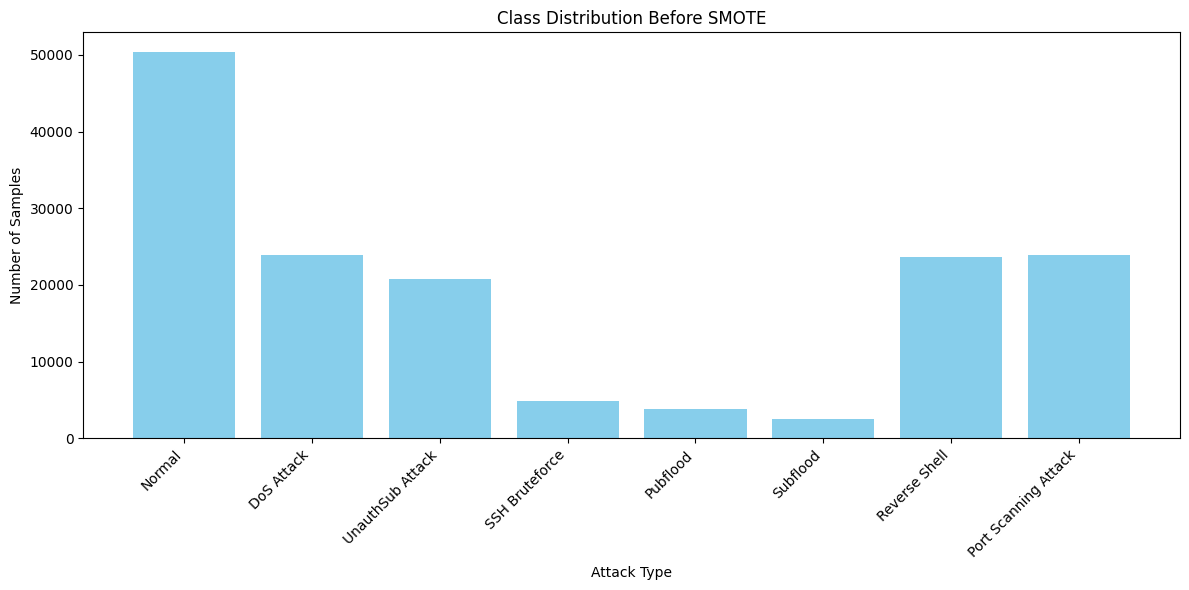

Total samples before SMOTE: 153770


In [39]:
# Plot class distribution before SMOTE
plt.figure(figsize=(12, 6))
class_counts = y_train.value_counts().sort_index()
attack_names = [list(attack_mapping.keys())[list(attack_mapping.values()).index(i)] for i in class_counts.index]
plt.bar(range(len(class_counts)), class_counts.values, color='skyblue')
plt.xlabel("Attack Type")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Before SMOTE")
plt.xticks(range(len(attack_names)), attack_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(f"Total samples before SMOTE: {len(y_train)}")

In [40]:
# Apply SMOTE to balance the training set
print("Applying SMOTE for class balancing...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("\nClass distribution after SMOTE:")
balanced_dist = y_train_balanced.value_counts().sort_index()
for label, count in balanced_dist.items():
    attack_name = [k for k, v in attack_mapping.items() if v == label][0]
    percentage = (count / len(y_train_balanced)) * 100
    print(f"{label} ({attack_name}): {count} ({percentage:.2f}%)")

print(f"\nTotal samples after SMOTE: {len(y_train_balanced)}")

Applying SMOTE for class balancing...

Class distribution after SMOTE:
0 (Normal): 50414 (12.50%)
1 (DoS Attack): 50414 (12.50%)
2 (UnauthSub Attack): 50414 (12.50%)
3 (SSH Bruteforce): 50414 (12.50%)
4 (Pubflood): 50414 (12.50%)
5 (Subflood): 50414 (12.50%)
6 (Reverse Shell): 50414 (12.50%)
7 (Port Scanning Attack): 50414 (12.50%)

Total samples after SMOTE: 403312

Class distribution after SMOTE:
0 (Normal): 50414 (12.50%)
1 (DoS Attack): 50414 (12.50%)
2 (UnauthSub Attack): 50414 (12.50%)
3 (SSH Bruteforce): 50414 (12.50%)
4 (Pubflood): 50414 (12.50%)
5 (Subflood): 50414 (12.50%)
6 (Reverse Shell): 50414 (12.50%)
7 (Port Scanning Attack): 50414 (12.50%)

Total samples after SMOTE: 403312


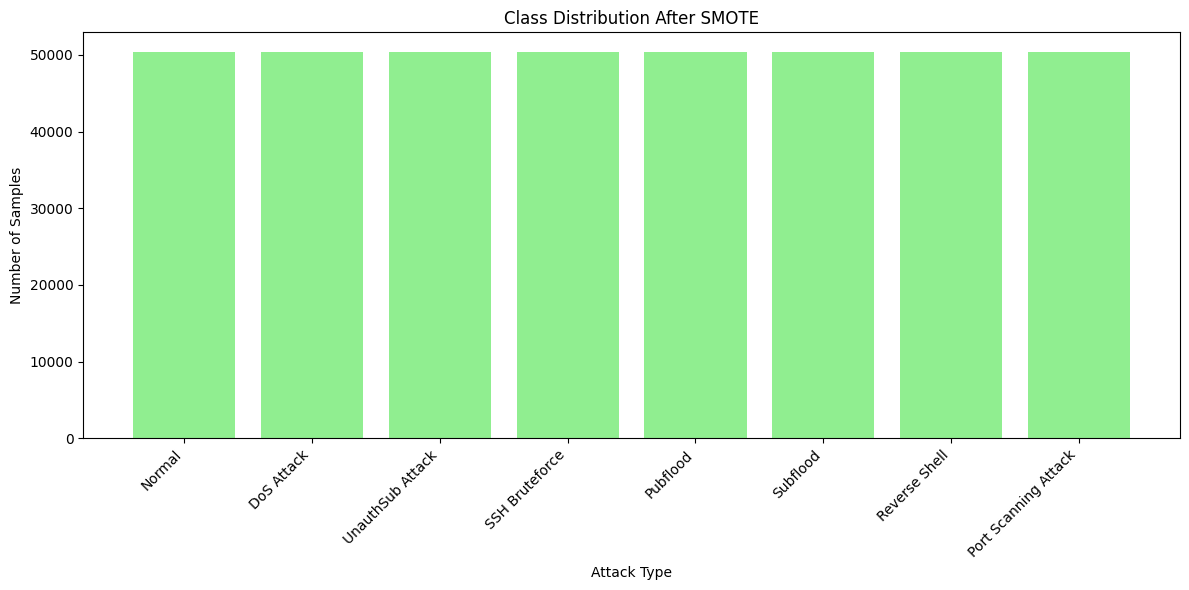

Balancing complete: 153770 -> 403312 samples


In [41]:
# Plot class distribution after SMOTE
plt.figure(figsize=(12, 6))
balanced_counts = y_train_balanced.value_counts().sort_index()
plt.bar(range(len(balanced_counts)), balanced_counts.values, color='lightgreen')
plt.xlabel("Attack Type")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After SMOTE")
plt.xticks(range(len(attack_names)), attack_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(f"Balancing complete: {len(X_train)} -> {len(X_train_balanced)} samples")

In [42]:
def scale_data(X_train, X_test, scale_data=True):
    """
    Scales the data if scale_data is True.
    """
    if scale_data:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

        X_test_scaled = scaler.transform(X_test)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
        
        print(f"Data scaled using StandardScaler")
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test
        scaler = None
        print(f"No scaling applied")

    return X_train_scaled, X_test_scaled, scaler

In [43]:
def compute_mutual_info(X_train_scaled, y_train):
    """
    Computes mutual information (MI) scores for the features in X_train.
    """
    print("Computing mutual information scores...")
    mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)

    # Create MI DataFrame with rank
    mi_df = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'MI_Score': mi_scores
    }).sort_values('MI_Score', ascending=False).reset_index(drop=True)
    mi_df['Rank'] = mi_df.index + 1
    
    print(f"Mutual information computed for {len(mi_df)} features")
    return mi_df

Data scaled using StandardScaler
Computing mutual information scores...
Mutual information computed for 78 features

[INFO] Top 20 Features by Mutual Information Scores:
              Feature  MI_Score  Rank
0            Dst Port  1.849307     1
1            Src Port  1.708136     2
2      Bwd Header Len  1.626523     3
3         Bwd IAT Tot  1.564036     4
4          Bwd Pkts/s  1.558314     5
5        Bwd IAT Mean  1.527549     6
6         Flow Pkts/s  1.505283     7
7        Pkt Len Mean  1.504975     8
8       Flow Duration  1.499958     9
9        Pkt Size Avg  1.498086    10
10        Bwd IAT Max  1.490994    11
11        Pkt Len Var  1.485513    12
12        Pkt Len Std  1.484862    13
13      Flow IAT Mean  1.467879    14
14    TotLen Bwd Pkts  1.462635    15
15   Subflow Bwd Byts  1.452563    16
16   Bwd Seg Size Avg  1.439567    17
17   Bwd Pkt Len Mean  1.439213    18
18       Flow IAT Max  1.401707    19
19  Init Bwd Win Byts  1.347714    20
Mutual information computed for 

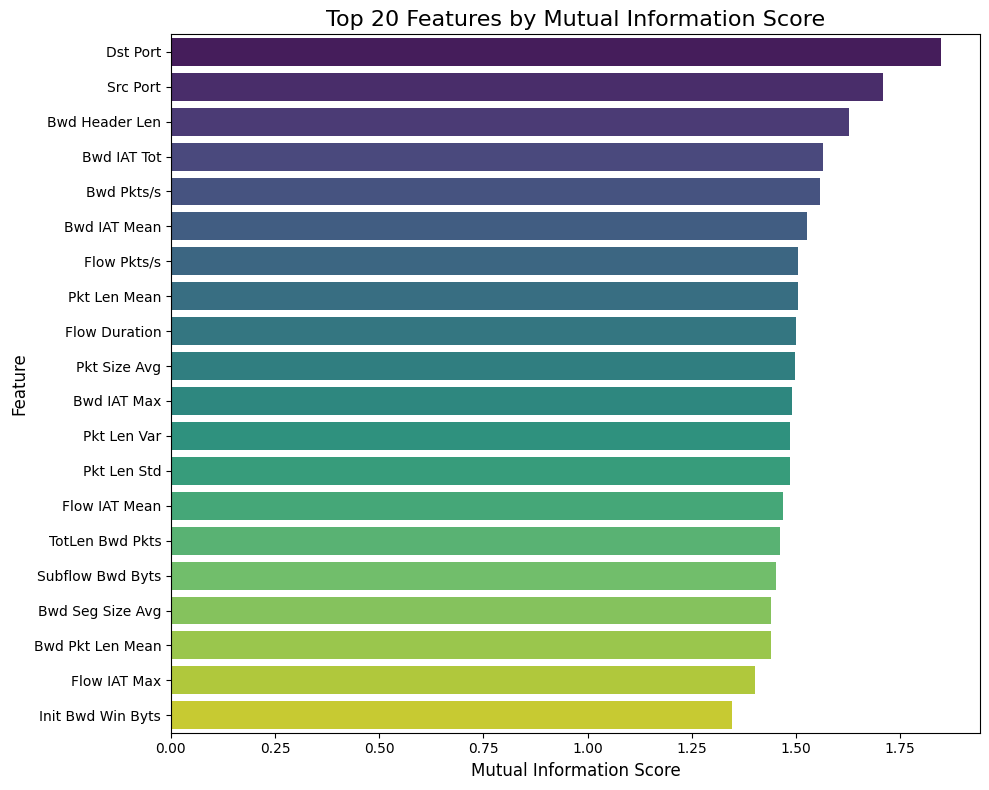


[INFO] Selected 62 features with MI score >= 0.01

Final feature set shape:
Training: (403312, 62)
Testing: (38443, 62)

Selected features: ['Dst Port', 'Src Port', 'Bwd Header Len', 'Bwd IAT Tot', 'Bwd Pkts/s', 'Bwd IAT Mean', 'Flow Pkts/s', 'Pkt Len Mean', 'Flow Duration', 'Pkt Size Avg']...

Final feature set shape:
Training: (403312, 62)
Testing: (38443, 62)

Selected features: ['Dst Port', 'Src Port', 'Bwd Header Len', 'Bwd IAT Tot', 'Bwd Pkts/s', 'Bwd IAT Mean', 'Flow Pkts/s', 'Pkt Len Mean', 'Flow Duration', 'Pkt Size Avg']...


In [44]:
def plot_top_features(mi_df, top_n=20):
    """
    Plots the top_n features based on their Mutual Information (MI) scores.
    """
    top_k = mi_df.head(top_n)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='MI_Score', y='Feature', data=top_k, palette='viridis')
    plt.title(f'Top {top_n} Features by Mutual Information Score', fontsize=16)
    plt.xlabel('Mutual Information Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

# Scale the data and get the scaler
X_train_scaled, X_test_scaled, scaler = scale_data(X_train_balanced, X_test, scale_data=True)

# Compute mutual information
mi_df = compute_mutual_info(X_train_scaled, y_train_balanced)

# Print Top 20 Features based on MI Scores
print("\n[INFO] Top 20 Features by Mutual Information Scores:")
print(mi_df.head(20))

# Plot the top 20 features
plot_top_features(mi_df, top_n=20)

# Select features based on the mutual information threshold
threshold = 0.01
selected_features = mi_df[mi_df['MI_Score'] >= threshold]['Feature'].tolist()
print(f"\n[INFO] Selected {len(selected_features)} features with MI score >= {threshold}")

# Apply feature selection to the data
X_train_selected = X_train_balanced[selected_features]
X_test_selected = X_test[selected_features]

# Re-scale the selected features
X_train_final = scaler.fit_transform(X_train_selected)
X_test_final = scaler.transform(X_test_selected)

print(f"\nFinal feature set shape:")
print(f"Training: {X_train_final.shape}")
print(f"Testing: {X_test_final.shape}")
print(f"\nSelected features: {selected_features[:10]}...")  # Show first 10 features

Performing PCA analysis...
Components needed for 95% variance: 18
Components needed for 95% variance: 18


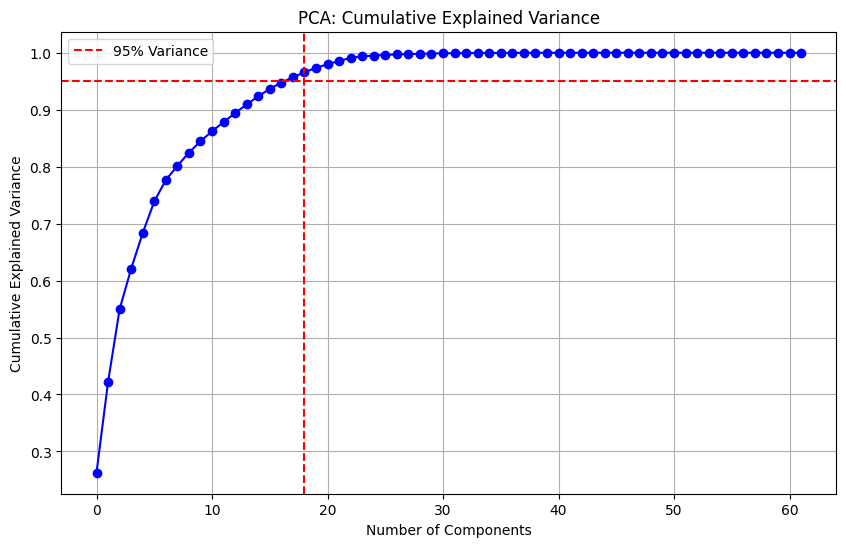

In [45]:
# PCA Analysis
print("Performing PCA analysis...")
pca = PCA()
pca.fit(X_train_final)  # X_train is your training data
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Find number of components for 95% variance
n_components_95 = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
print(f"Components needed for 95% variance: {n_components_95}")

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axvline(x=n_components_95, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# Metrics calculation function
def calculate_metrics(y_true, y_pred):
    """Calculate various classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

    return metrics

def display_metrics(metrics):
    """Display metrics in a formatted way"""
    print("\nModel Performance Metrics:")
    print("-" * 30)
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.ljust(12)}: {metric_value * 100:.2f}%")
    print("-" * 30)

In [47]:
# Train a base KNN model before hyperparameter tuning
print("Training base KNN model...")
knn_base = KNeighborsClassifier(n_neighbors=5)
knn_base.fit(X_train_final, y_train_balanced)
knn_base_preds = knn_base.predict(X_test_final)

# Calculate and display base model metrics
base_metrics = calculate_metrics(y_test, knn_base_preds)
print("\n=== BASE KNN MODEL RESULTS ===")
display_metrics(base_metrics)
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, knn_base_preds))

Training base KNN model...

=== BASE KNN MODEL RESULTS ===

Model Performance Metrics:
------------------------------
Accuracy    : 98.65%
Precision   : 98.65%
Recall      : 98.65%
F1-score    : 98.65%
------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12603
           1       1.00      1.00      1.00      5978
           2       1.00      1.00      1.00      5183
           3       1.00      1.00      1.00      1227
           4       1.00      1.00      1.00       943
           5       0.99      1.00      0.99       625
           6       0.96      0.96      0.96      5905
           7       0.96      0.96      0.96      5979

    accuracy                           0.99     38443
   macro avg       0.99      0.99      0.99     38443
weighted avg       0.99      0.99      0.99     38443


=== BASE KNN MODEL RESULTS ===

Model Performance Metrics:
-----------------------

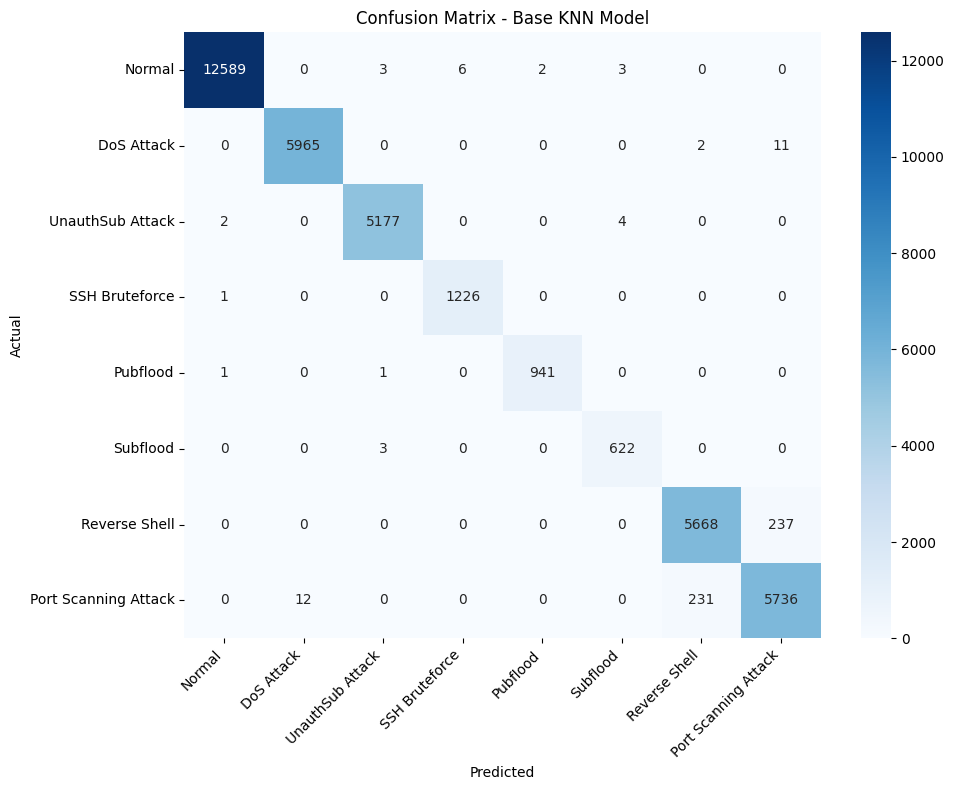

In [48]:
# Generate confusion matrix for base model
conf_matrix_base = confusion_matrix(y_test, knn_base_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=attack_names,
            yticklabels=attack_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Base KNN Model')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [49]:
# Define the Optuna objective function for hyperparameter tuning
def objective(trial):
    """Optuna objective function for KNN hyperparameter optimization"""
    # Define hyperparameters to optimize
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    p = trial.suggest_int('p', 1, 2)  # p=1 for Manhattan, p=2 for Euclidean

    # Create and train the KNN model
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        p=p
    )

    # Use cross-validation to evaluate model performance
    score = 0
    try:
        knn.fit(X_train_final, y_train_balanced)
        y_pred = knn.predict(X_test_final)
        score = f1_score(y_test, y_pred, average='weighted') # Optimize for F1 score
    except Exception as e:
        print(f"Exception in Optuna trial: {e}")
        return 0.0

    return score

# Run Optuna optimization
print("\n=== STARTING HYPERPARAMETER OPTIMIZATION ===")
print("Running Optuna optimization with 20 trials...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Get the best hyperparameters
best_params = study.best_params
print(f"\nOptimization completed!")
print(f"Best F1 score: {study.best_value:.4f}")
print(f"Best hyperparameters: {best_params}")

[I 2025-09-24 10:34:18,545] A new study created in memory with name: no-name-288d32af-3c1c-4885-9251-a190e7e1c26c



=== STARTING HYPERPARAMETER OPTIMIZATION ===
Running Optuna optimization with 20 trials...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-09-24 10:34:28,898] Trial 0 finished with value: 0.9789328538933312 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'auto', 'p': 2}. Best is trial 0 with value: 0.9789328538933312.
[I 2025-09-24 10:35:22,527] Trial 1 finished with value: 0.9900905614474699 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'algorithm': 'brute', 'p': 1}. Best is trial 1 with value: 0.9900905614474699.
[I 2025-09-24 10:35:22,527] Trial 1 finished with value: 0.9900905614474699 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'algorithm': 'brute', 'p': 1}. Best is trial 1 with value: 0.9900905614474699.
[I 2025-09-24 10:35:33,212] Trial 2 finished with value: 0.9859295614352336 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'algorithm': 'brute', 'p': 2}. Best is trial 1 with value: 0.9900905614474699.
[I 2025-09-24 10:35:33,212] Trial 2 finished with value: 0.9859295614352336 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'algorithm'

In [50]:
# Train a new model with the best hyperparameters
print("\n=== TRAINING OPTIMIZED KNN MODEL ===")
print("Training KNN with optimized hyperparameters...")
knn_optimized = KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'],
    weights=best_params['weights'],
    algorithm=best_params['algorithm'],
    p=best_params['p']
)

knn_optimized.fit(X_train_final, y_train_balanced)
knn_optimized_preds = knn_optimized.predict(X_test_final)

# Calculate and display optimized model metrics
optimized_metrics = calculate_metrics(y_test, knn_optimized_preds)
print("\n=== OPTIMIZED KNN MODEL RESULTS ===")
display_metrics(optimized_metrics)

# Compare with base model
print("\n=== MODEL COMPARISON ===")
print(f"{'Metric':<12} {'Base KNN':<12} {'Optimized KNN':<15} {'Improvement':<12}")
print("-" * 55)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
    base_val = base_metrics[metric] * 100
    opt_val = optimized_metrics[metric] * 100
    improvement = opt_val - base_val
    print(f"{metric:<12} {base_val:<12.2f} {opt_val:<15.2f} {improvement:<12.2f}")


=== TRAINING OPTIMIZED KNN MODEL ===
Training KNN with optimized hyperparameters...

=== OPTIMIZED KNN MODEL RESULTS ===

Model Performance Metrics:
------------------------------
Accuracy    : 99.15%
Precision   : 99.15%
Recall      : 99.15%
F1-score    : 99.15%
------------------------------

=== MODEL COMPARISON ===
Metric       Base KNN     Optimized KNN   Improvement 
-------------------------------------------------------
Accuracy     98.65        99.15           0.50        
Precision    98.65        99.15           0.50        
Recall       98.65        99.15           0.50        
F1-score     98.65        99.15           0.50        

=== OPTIMIZED KNN MODEL RESULTS ===

Model Performance Metrics:
------------------------------
Accuracy    : 99.15%
Precision   : 99.15%
Recall      : 99.15%
F1-score    : 99.15%
------------------------------

=== MODEL COMPARISON ===
Metric       Base KNN     Optimized KNN   Improvement 
-------------------------------------------------------

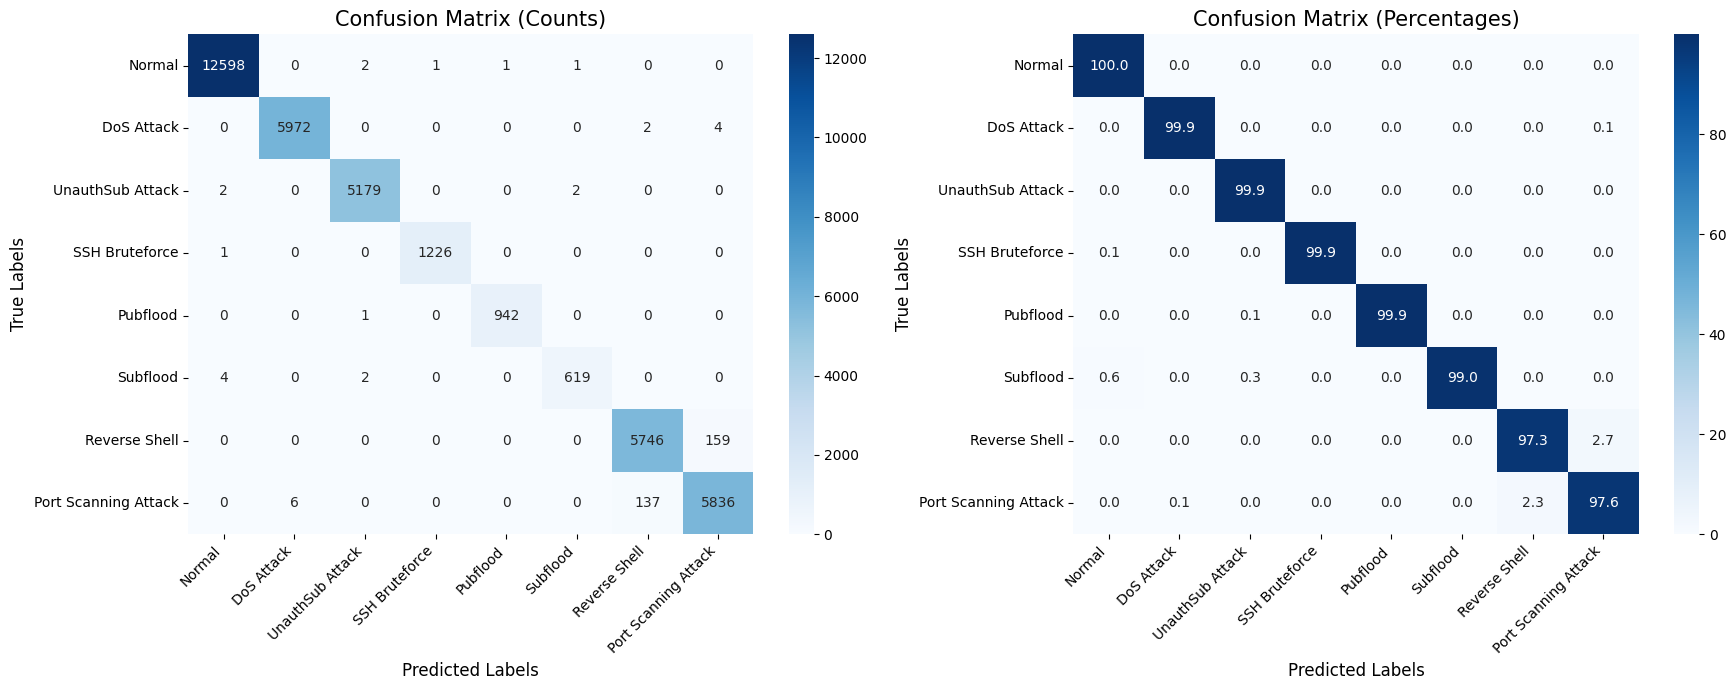


=== DETAILED CLASSIFICATION REPORT ===
                      precision    recall  f1-score   support

              Normal       1.00      1.00      1.00     12603
          DoS Attack       1.00      1.00      1.00      5978
    UnauthSub Attack       1.00      1.00      1.00      5183
      SSH Bruteforce       1.00      1.00      1.00      1227
            Pubflood       1.00      1.00      1.00       943
            Subflood       1.00      0.99      0.99       625
       Reverse Shell       0.98      0.97      0.97      5905
Port Scanning Attack       0.97      0.98      0.97      5979

            accuracy                           0.99     38443
           macro avg       0.99      0.99      0.99     38443
        weighted avg       0.99      0.99      0.99     38443


Overall Accuracy: 0.9915


In [51]:
# Create comprehensive confusion matrix visualization
cm = confusion_matrix(y_test, knn_optimized_preds)

# Create a figure with two subplots
plt.figure(figsize=(18, 7))

# Plot 1: Confusion Matrix (Counts)
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=attack_names,
            yticklabels=attack_names)
plt.title('Confusion Matrix (Counts)', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Plot 2: Confusion Matrix (Percentages)
plt.subplot(1, 2, 2)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', cbar=True,
            xticklabels=attack_names,
            yticklabels=attack_names)
plt.title('Confusion Matrix (Percentages)', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Print detailed classification report
print('\n=== DETAILED CLASSIFICATION REPORT ===')
print(classification_report(y_test, knn_optimized_preds, target_names=attack_names))

# Print overall accuracy
print(f'\nOverall Accuracy: {accuracy_score(y_test, knn_optimized_preds):.4f}')

In [ ]:
# Save the trained model, scaler, and feature information
print("\n=== SAVING MODEL AND RELATED FILES ===")

# Save the optimized KNN model
model_path = "model.joblib"
dump(knn_optimized, model_path)
print(f"✅ Model saved as: {model_path}")

# Save the scaler
scaler_path = "scaler.joblib"
dump(scaler, scaler_path)
print(f"✅ Scaler saved as: {scaler_path}")

# Save the selected features
features_path = "features.txt"
with open(features_path, 'w') as f:
    for feature in selected_features:
        f.write(f"{feature}\n")
print(f"✅ Selected features saved as: {features_path} ({len(selected_features)} features)")

# Save the used features (for reference)
used_features_path = "used_features.txt"
with open(used_features_path, 'w') as f:
    f.write(f"Total features used: {len(selected_features)}\n")
    f.write(f"Mutual information threshold: {threshold}\n")
    f.write(f"Model type: K-Nearest Neighbors\n")
    f.write(f"Best hyperparameters: {best_params}\n")
    f.write(f"Final accuracy: {optimized_metrics['Accuracy']:.4f}\n")
    f.write(f"\nSelected features:\n")
    for i, feature in enumerate(selected_features, 1):
        f.write(f"{i}. {feature}\n")
print(f"✅ Feature usage info saved as: {used_features_path}")

# Create a README file
readme_path = "readme.md" 
with open(readme_path, 'w') as f:
    f.write("# AC-MI-KNN Model\n\n")
    f.write("## K-Nearest Neighbors with Mutual Information Feature Selection\n\n")
    f.write("### Model Details:\n")
    f.write(f"- **Algorithm**: K-Nearest Neighbors Classifier\n")
    f.write(f"- **Features**: {len(selected_features)} selected using Mutual Information (MI ≥ {threshold})\n")
    f.write(f"- **Data Balancing**: SMOTE (Synthetic Minority Oversampling Technique)\n")
    f.write(f"- **Scaling**: StandardScaler\n")
    f.write(f"- **Hyperparameter Optimization**: Optuna (20 trials)\n\n")
    f.write("### Best Hyperparameters:\n")
    for param, value in best_params.items():
        f.write(f"- **{param}**: {value}\n")
    f.write("\n### Performance Metrics:\n")
    for metric, value in optimized_metrics.items():
        f.write(f"- **{metric}**: {value*100:.2f}%\n")
    f.write("\n### Files:\n")
    f.write("- `model.joblib`: Trained KNN model\n")
    f.write("- `scaler.joblib`: StandardScaler for feature preprocessing\n")
    f.write("- `features.txt`: List of selected features\n")
    f.write("- `used_features.txt`: Detailed feature usage information\n")
    f.write("- `acmiknn.ipynb`: Training notebook\n")
print(f"✅ README saved as: {readme_path}")

print("\n=== MODEL TRAINING COMPLETE ===")
print(f"All files saved in: {os.getcwd()}")
print(f"Model ready for deployment and validation testing!")


=== SAVING MODEL AND RELATED FILES ===
✅ Model saved as: model.joblib
✅ Scaler saved as: scaler.joblib
✅ Selected features saved as: features.txt (62 features)
✅ Feature usage info saved as: used_features.txt
✅ README saved as: readme.md

=== MODEL TRAINING COMPLETE ===
All files saved in: c:\Users\B760M-ITX D4 WIFI\Documents\GitHub\ros-security\dataset\models\ac-mi-knn
Model ready for deployment and validation testing!
✅ Model saved as: model.joblib
✅ Scaler saved as: scaler.joblib
✅ Selected features saved as: features.txt (62 features)
✅ Feature usage info saved as: used_features.txt
✅ README saved as: readme.md

=== MODEL TRAINING COMPLETE ===
All files saved in: c:\Users\B760M-ITX D4 WIFI\Documents\GitHub\ros-security\dataset\models\ac-mi-knn
Model ready for deployment and validation testing!
